## Tackle the Titanic dataset. A great place to start is on Kaggle.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
import os
import re
from pathlib import Path

In [3]:
path = Path("./Titanic/")

In [4]:
train_set = pd.read_csv(path/"train.csv")
test_set = pd.read_csv(path/"test.csv")
y_label_test_set = pd.read_csv(path/"gender_submission.csv")

In [5]:
test_set = test_set.merge(y_label_test_set,on="PassengerId")

In [6]:
dataset = pd.concat([train_set,test_set],sort=False)

In [7]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


**As we can see, we have null values to impute...** 

And some features will be dropped as they are not valuable (like name...)

In [9]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Survived,1309.0,0.377387,0.484918,0.00,0.0000,0.0000,1.000,1.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292


**Some values don't make sense at all, like the min age of 0.42!**

/home/alex/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/alex/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/alex/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/alex/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


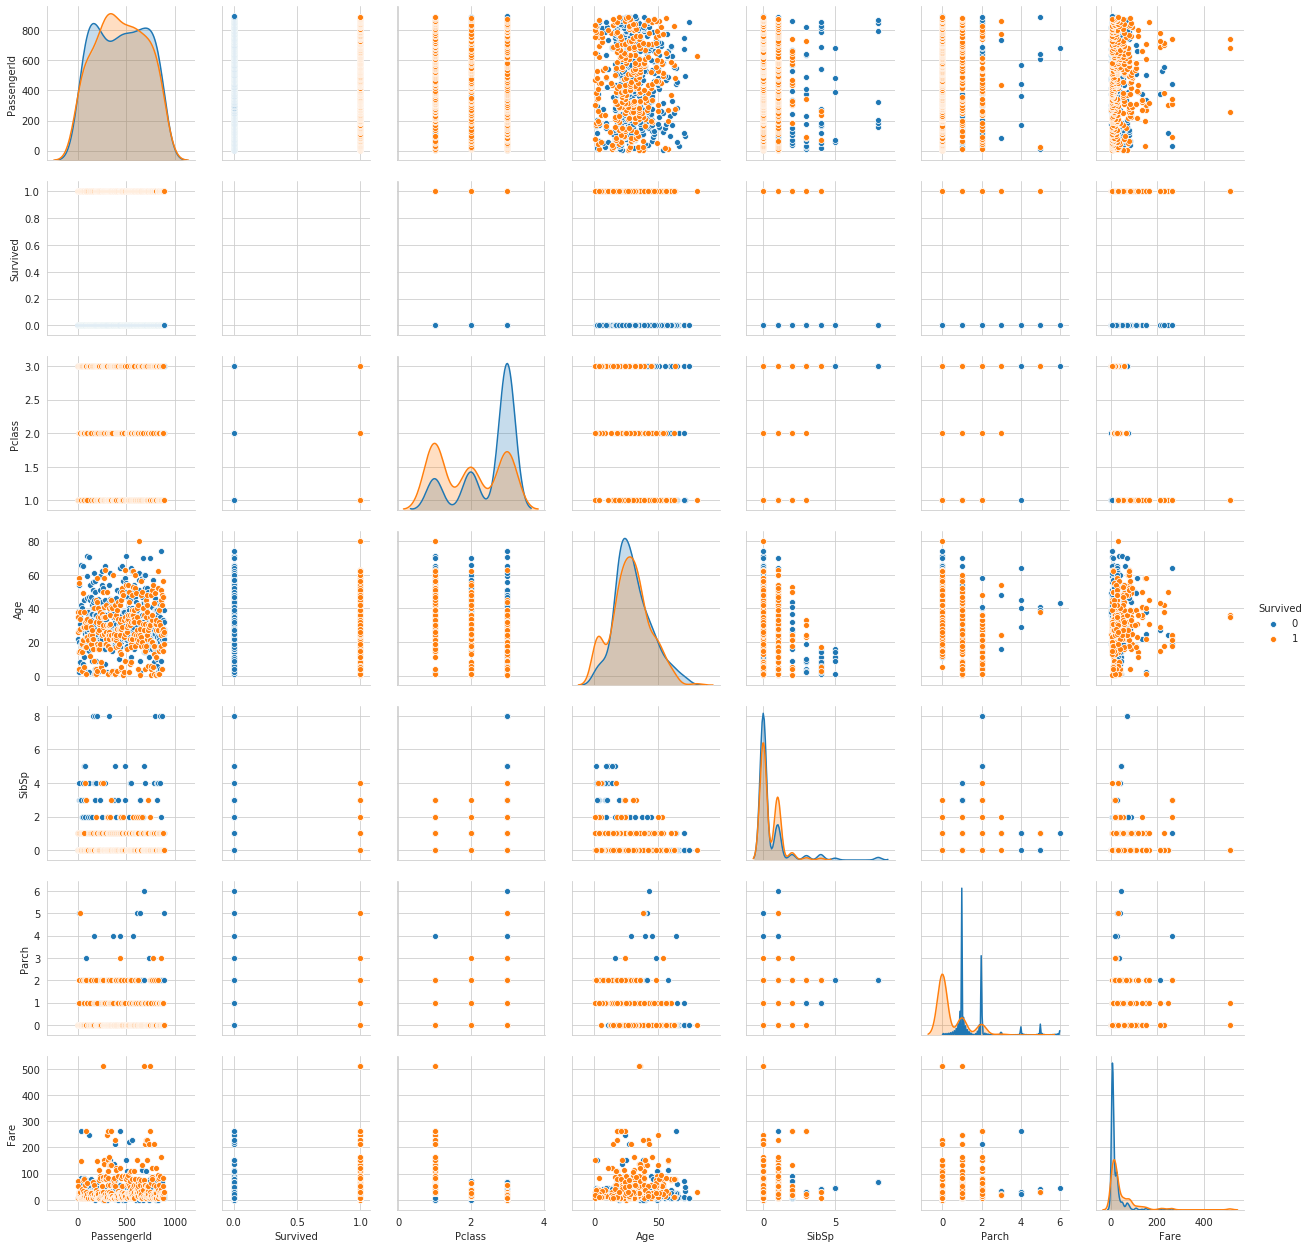

In [10]:
sns.pairplot(train_set,hue="Survived")

**The distribution are really positively skew, maybe because of outliers?**

In [11]:
corr_matrix = dataset.corr()

[]

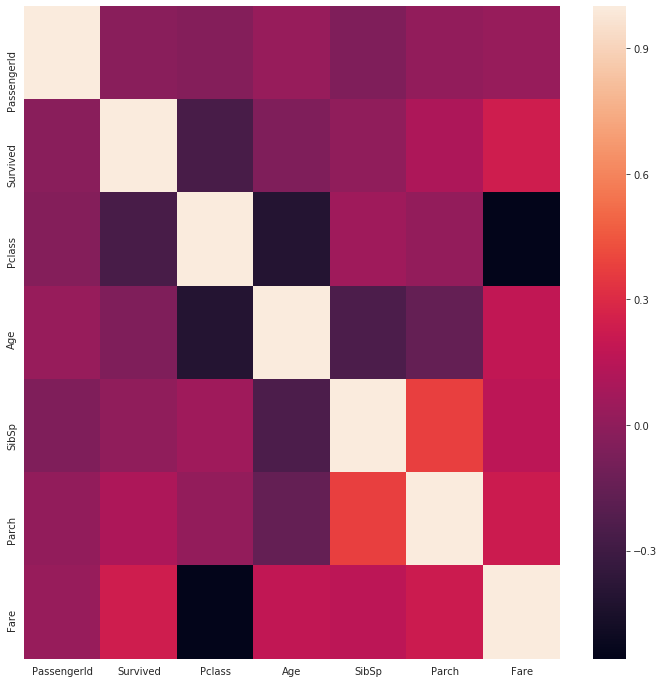

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix)
plt.plot()

In [13]:
#Some variables are strongly correlated between themselves...

0    815
1    494
Name: Survived, dtype: int64


0    91.470258
1    55.443322
Name: Survived, dtype: float64


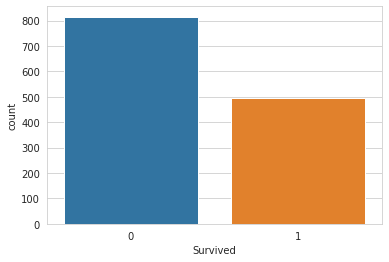

In [14]:
print(dataset["Survived"].value_counts())
print("\n")
print(dataset["Survived"].value_counts() / len(train_set) * 100)
sns.countplot(dataset['Survived'])

**The distribution of the survived versus the no-survived is unven with more survived than no survived.**

In [15]:
#We separe the target from the data
X = dataset.drop(columns="Survived")
y = dataset["Survived"]

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
#We split the data with a stratified split
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(X,y):
    strat_train_set = dataset.iloc[train_index]
    strat_test_set = dataset.iloc[test_index]

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
#Preparing fata for the first machine learning algorithm

survived = strat_train_set.drop(columns="Survived")
survived_label = strat_train_set["Survived"].copy()

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

In [21]:
class DropColumns(BaseEstimator, TransformerMixin):
    """Drop the columns in a dataframe """
    def __init__(self, column_names=[]):
        self.column_names = column_names
    def transform(self, df, y=None):
        """drop the columns present in self.columns"""
        return df.drop(self.column_names, axis=1)
    def fit(self, df, y=None):
        """Pass"""
        return self

In [22]:
class Create_Titles(BaseEstimator, TransformerMixin):
    """Takes in the name of the passenger and return their title."""
    def __init__(self):
        pass        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["Title"] = X["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
        X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                                   'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                                                   'Jonkheer', 'Dona'], 'Rare')

        X['Title'] = X['Title'].replace('Mlle', 'Miss')
        X['Title'] = X['Title'].replace('Ms', 'Miss')
        X['Title'] = X['Title'].replace('Mme', 'Mrs')

        return X

In [23]:
class Family_Size(BaseEstimator,TransformerMixin):
    """Calculates the size of the family for each passanger"""
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self    
    def transform(self,X,y=None):
        """Creation of the new feature"""
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X.drop(columns=["SibSp","Parch"],inplace=True)
        return X

In [24]:
#We are using OneHotEncoder and not OrdinalEncoder due to the lack of ordination in our features.
pipeline_num = Pipeline([
    ["dropping_col",DropColumns(["PassengerId"])],
    ["imputer",SimpleImputer(strategy = "median")],
    ["standardscaler",StandardScaler()]
])

In [25]:
pipeline_cat = Pipeline([
    ["Create_Titles",Create_Titles()],
    ["dropping_col",DropColumns(["Name","Ticket"])],
    ["FamilySize",Family_Size()],
    ["Imputer",SimpleImputer(strategy="most_frequent")],
    ["OneHotEncoder",OneHotEncoder(handle_unknown="ignore")]
])

In [26]:
num_attribs = ["Age","Fare","PassengerId"]
cat_attribs = list(survived.drop(columns=["Age","Fare"]))

In [27]:
full_pipeline = ColumnTransformer([
                ("num",pipeline_num,num_attribs),
                ("cat",pipeline_cat,cat_attribs),    
                ])

In [28]:
Model = Pipeline([
    ('Rf',RandomForestClassifier(n_jobs=-1,random_state=42))
                            ])

In [29]:
model_pipeline = Pipeline([
    ('transformation_pipeline',full_pipeline),
    ('model',Model)])

In [30]:
#GridSearch

param_grid = [
    {'model__Rf__n_estimators' : np.arange(1,1000,200)},
    {'transformation_pipeline__num__imputer__strategy':["median","mean","most_frequent"]}]

grid_search = GridSearchCV(model_pipeline,param_grid,cv=3,scoring="accuracy",return_train_score=True)

grid_search.fit(survived,survived_label)


print(f"Our best parameters: {grid_search.best_params_}")
print(f"Our best estimator: {grid_search.best_estimator_}")
print(f"Our best score: {grid_search.best_score_}")

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/skl

Our best parameters: {'model__Rf__n_estimators': 201}
Our best estimator: Pipeline(memory=None,
         steps=[('transformation_pipeline',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[['dropping_col',
                                                                   DropColumns(column_names=['PassengerId'])],
                                                                  ['imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 

In [31]:
from scikitplot.metrics import plot_confusion_matrix,\
                               plot_precision_recall,\
                               plot_roc_curve


from sklearn.metrics import precision_score,\
                            recall_score,\
                            f1_score,\
                            accuracy_score,\
                            confusion_matrix,\
                            roc_curve,\
                            roc_auc_score,\
                            classification_report

In [32]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.figure(figsize=(12,8))
    plt.plot(fpr,tpr,linewidth = 2,label=label)
    plt.plot([0,1],[0,1],"k--") #Dashed diagonal
    plt.ylabel("True Positive Rate (FPR) / Recall / Sensitivity")
    plt.xlabel("True Negative Rate (FPR) /1- Specificity")
    plt.legend()

In [33]:
def print_metrics(predicted_y,y_test):
    
    fpr , tpr, thresholds = roc_curve(predicted_y,y_test)
    
    plot_roc_curve(fpr , tpr)
    plt.show()
    
    print(f"The area under the roc curve is {roc_auc_score(predicted_y,y_test)}")
    
   
    print("\n")
    print(f"Accuracy Score : {(accuracy_score(predicted_y,y_test))}")
    print(f"Precision Score : {(precision_score(predicted_y,y_test))}")
    print(f"Recall Score : {(recall_score(predicted_y,y_test))}")
    print(f"F1 Score : {(f1_score(predicted_y,y_test))}")
    print("\n")
    print(plot_confusion_matrix(predicted_y,y_test))
    print(f"{classification_report(predicted_y,y_test)}")

In [34]:
survived_test = strat_test_set.drop(columns="Survived")
survived__test_label = strat_test_set["Survived"].copy()

In [35]:
predicted_y = grid_search.predict(survived_test)

No handles with labels found to put in legend.


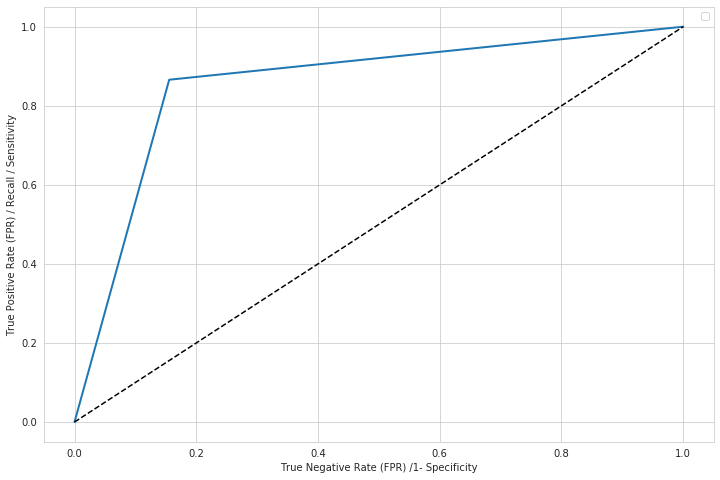

The area under the roc curve is 0.8551490514905148


Accuracy Score : 0.851145038167939
Precision Score : 0.7171717171717171
Recall Score : 0.8658536585365854
F1 Score : 0.7845303867403315


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       180
           1       0.72      0.87      0.78        82

    accuracy                           0.85       262
   macro avg       0.82      0.86      0.84       262
weighted avg       0.87      0.85      0.85       262



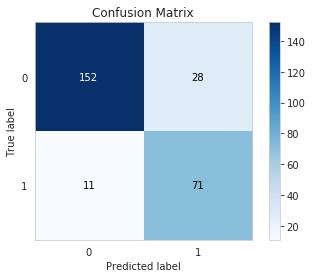

In [36]:
print_metrics(predicted_y,survived__test_label)